## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import shutil
import keras
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
mass_train = pd.read_csv('./Data/Cleaned csv/Mass train cleaned.csv')
calc_train = pd.read_csv('./Data/Cleaned csv/Calc train cleaned.csv')

In [3]:
mass_train['label'] = mass_train['pathology'].str.replace('_WITHOUT_CALLBACK','').apply(lambda x: x.lower())
calc_train['label'] = calc_train['pathology'].str.replace('_WITHOUT_CALLBACK','').apply(lambda x: x.lower())

In [4]:
mass_train.shape

(1318, 15)

In [5]:
calc_train.shape

(1544, 15)

In [6]:
label_count = mass_train['label'].value_counts()
print(label_count)

label
benign       681
malignant    637
Name: count, dtype: int64


In [7]:
label_count = calc_train['label'].value_counts()
print(label_count)

label
benign       1001
malignant     543
Name: count, dtype: int64


In [8]:
labels = mass_train.label.unique()
C_mass = len(labels)
print(f"There are {C_mass} total labels of mass results")
labels[:4]

There are 2 total labels of mass results


array(['malignant', 'benign'], dtype=object)

In [9]:
labels = calc_train.label.unique()
C_calc = len(labels)
print(f"There are {C_calc} total labels of calc results")
labels[:4]

There are 2 total labels of calc results


array(['malignant', 'benign'], dtype=object)

## Read in images

### Create New Train Images Directory

In [10]:
def clear_and_mkdir(d):
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

for label in labels:
    clear_and_mkdir(f'./Data/restructured jpeg/train/mass/{label}')
    clear_and_mkdir(f'./Data/restructured jpeg/train/calc/{label}')


File is:./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg and label is: malignant, combname is 1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg, dirname is 1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515
File is:./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg and label is: malignant, combname is 1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg, dirname is 1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834
File is:./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg and label is: benign, combname is 1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg, dirname is 1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540
File is:./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg and label is: benign, combname is 1.3.6.1.4.1.9590.100.1.2.

In [ ]:
# for i,row in mass_train.head().iterrows():
#     file,label = row['image_file_path'], row['label']
#     filename = os.path.basename(file)
#     dirname = os.path.dirname(file).split('/')[-1]
#     combname = os.path.join(dirname, filename)
#     print(f"File is:{file} and label is: {label}, combname is {combname}, dirname is {dirname}")

# for i,row in calc_train.head().iterrows():
#     file,label = row['image_file_path'], row['label']
#     filename = os.path.basename(file)
#     dirname = os.path.dirname(file).split('/')[-1]
#     combname = os.path.join(dirname, filename)
#     print(f"File is:{file} and label is: {label}, combname is {combname}, dirname is {dirname}")

# file = mass_train.image_file_path.iloc[0]

# os.path.basename(file)

# os.path.dirname(file).split('/')


#### Copy Original Images into New Image Folder in New Structure

##### Mass Images

In [28]:
for i,row in mass_train.iterrows():
    file,label = row['image_file_path'], row['label']
    src = file
    filename = os.path.basename(file)
    dirname = os.path.dirname(file).split('/')[-1]
    imagefolder = dirname+'-'+filename
    dest = f'./Data/restructured jpeg/train/mass/{label}/{imagefolder}' 
    shutil.copy(src, dest)

mass_train_ds = image_dataset_from_directory(
    'Data/restructured jpeg/train/mass',
    batch_size=32,
    subset='training',
    seed=123,
    image_size=(512, 512),
    label_mode='binary',
    color_mode ='rgb',
    validation_split=0.2,
).map(lambda x, y: (x/255, y))

mass_val_ds = image_dataset_from_directory(
    'Data/restructured jpeg/train/mass',
    batch_size=32,
    subset='validation',
    seed=123,
    image_size=(512, 512),
    label_mode='binary',
    color_mode ='rgb',
    validation_split=0.2,
).map(lambda x, y: (x/255, y))


Found 1237 files belonging to 2 classes.
Using 990 files for training.
Found 1237 files belonging to 2 classes.
Using 247 files for validation.


##### Calcification Images

In [29]:
for i,row in calc_train.iterrows():
    file,label = row['image_file_path'], row['label']
    src = file
    filename = os.path.basename(file)
    dirname = os.path.dirname(file).split('/')[-1]
    imagefolder = dirname+'-'+filename
    dest = f'./Data/restructured jpeg/train/calc/{label}/{imagefolder}' 
    shutil.copy(src, dest)

calc_train_ds = image_dataset_from_directory(
    'Data/restructured jpeg/train/calc',
    batch_size=32,
    subset='training',
    seed=123,
    image_size=(512, 512),
    label_mode='binary',
    color_mode ='rgb',
    validation_split=0.2,
).map(lambda x, y: (x/255, y))

calc_val_ds = image_dataset_from_directory(
    'Data/restructured jpeg/train/calc',
    batch_size=32,
    subset='validation',
    seed=123,
    image_size=(512, 512),
    label_mode='binary',
    color_mode ='rgb',
    validation_split=0.2,
).map(lambda x, y: (x/255, y))

Found 1233 files belonging to 2 classes.
Using 987 files for training.
Found 1233 files belonging to 2 classes.
Using 246 files for validation.


## Modeling

### Basic CNN Model

In [30]:
# early stopping regulariazation
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [31]:
model_cnn = Sequential()

# add layers 
model_cnn.add(Conv2D(32, (3, 3), activation='relu',  input_shape=(512, 512, 3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1024, activation='relu')) 
model_cnn.add(Dense(1, activation='sigmoid'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
model_cnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [75]:
model_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,909,765 (297.20 MB)

 Trainable params: 25,969,921 (99.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,939,844 (198.13 MB)

In [33]:
hist_cnn = model_cnn.fit(
    mass_train_ds, 
    validation_data=mass_val_ds, 
    epochs=5,
    batch_size = 32,
    callbacks=[early_stopping]
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 290s 9s/step - acc: 0.4801 - loss: 0.7380 - val_acc: 0.5506 - val_loss: 0.6929
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 285s 9s/step - acc: 0.5272 - loss: 0.6930 - val_acc: 0.5344 - val_loss: 0.6910
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 258s 8s/step - acc: 0.5374 - loss: 0.6914 - val_acc: 0.4494 - val_loss: 0.6963
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - acc: 0.5330 - loss: 0.6916 - val_acc: 0.5506 - val_loss: 0.6848
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - acc: 0.5635 - loss: 0.6809 - val_acc: 0.5709 - val_loss: 0.6875


In [35]:
hist_cnn_calc = model_cnn.fit(
    calc_train_ds, 
    validation_data=calc_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - acc: 0.5500 - loss: 0.6862 - val_acc: 0.6341 - val_loss: 0.6555
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - acc: 0.6382 - loss: 0.6469 - val_acc: 0.6341 - val_loss: 0.6588
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 255s 8s/step - acc: 0.6490 - loss: 0.6396 - val_acc: 0.6382 - val_loss: 0.6338
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 320s 10s/step - acc: 0.6816 - loss: 0.5920 - val_acc: 0.6057 - val_loss: 0.6264
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 310s 10s/step - acc: 0.7294 - loss: 0.5503 - val_acc: 0.6098 - val_loss: 0.6599


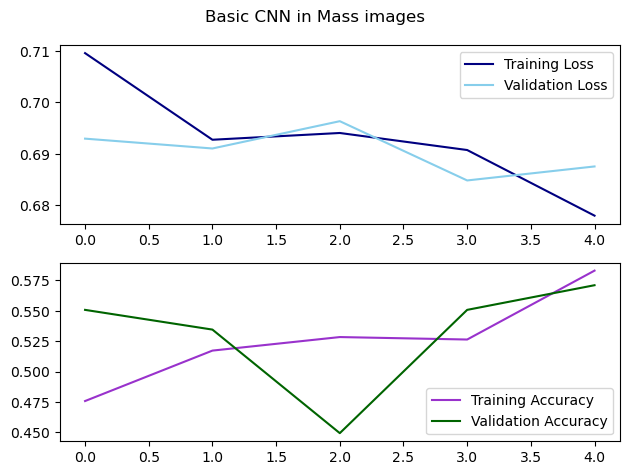

In [110]:
fig, axs = plt.subplots(2)
fig.suptitle("Basic CNN in Mass images")
# plt.figure(figsize =(6,5))
axs[0].plot(hist_cnn.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_cnn.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_cnn.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_cnn.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')

axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Mass Basic CNN Loss and Accuracy.jpg',dpi = 200);

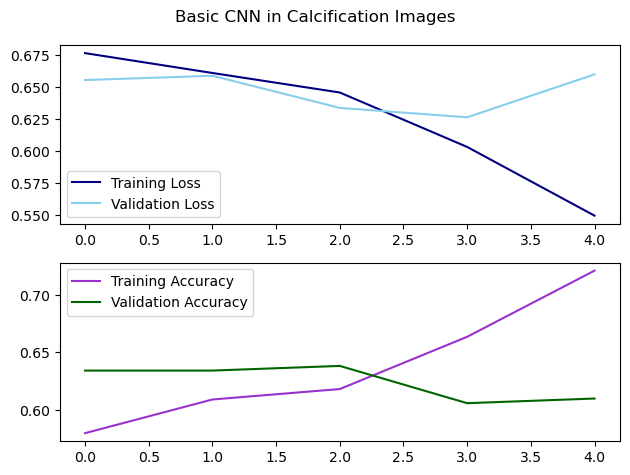

In [109]:
fig, axs = plt.subplots(2)
fig.suptitle("Basic CNN in Calcification Images")
# plt.figure(figsize =(6,5))
axs[0].plot(hist_cnn_calc.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_cnn_calc.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_cnn_calc.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_cnn_calc.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')

axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Calc Basic CNN Loss and Accuracy.jpg',dpi = 200);

### CNN with Data augmentation

In [42]:
data_aug = keras.models.Sequential([
    RandomFlip('horizontal_and_vertical', input_shape=(512, 512, 3)),
    RandomRotation(0.2),
    RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

In [43]:
inputs = keras.Input(shape=(512, 512, 3))
x = data_aug(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_aug = keras.Model(inputs, outputs)

In [44]:
model_aug.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [80]:
model_aug.summary()

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,909,765 (297.20 MB)

 Trainable params: 25,969,921 (99.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,939,844 (198.13 MB)

In [45]:
hist_aug = model_aug.fit(
    mass_train_ds, 
    validation_data=mass_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 330s 10s/step - acc: 0.5016 - loss: 0.7162 - val_acc: 0.5506 - val_loss: 0.6918
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 323s 10s/step - acc: 0.4899 - loss: 0.6936 - val_acc: 0.5506 - val_loss: 0.6922
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 280s 9s/step - acc: 0.5184 - loss: 0.6929 - val_acc: 0.5506 - val_loss: 0.6919
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 284s 9s/step - acc: 0.5258 - loss: 0.6926 - val_acc: 0.5506 - val_loss: 0.6925
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 286s 9s/step - acc: 0.5358 - loss: 0.6927 - val_acc: 0.5506 - val_loss: 0.6924


In [46]:
hist_aug_calc = model_aug.fit(
    calc_train_ds, 
    validation_data=calc_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 376s 12s/step - acc: 0.6037 - loss: 0.6902 - val_acc: 0.6098 - val_loss: 0.6808
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 350s 11s/step - acc: 0.6175 - loss: 0.6785 - val_acc: 0.6098 - val_loss: 0.6714
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 356s 11s/step - acc: 0.6055 - loss: 0.6733 - val_acc: 0.6098 - val_loss: 0.6725
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 377s 12s/step - acc: 0.6119 - loss: 0.6707 - val_acc: 0.6098 - val_loss: 0.6700
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 351s 11s/step - acc: 0.6201 - loss: 0.6683 - val_acc: 0.6098 - val_loss: 0.6702


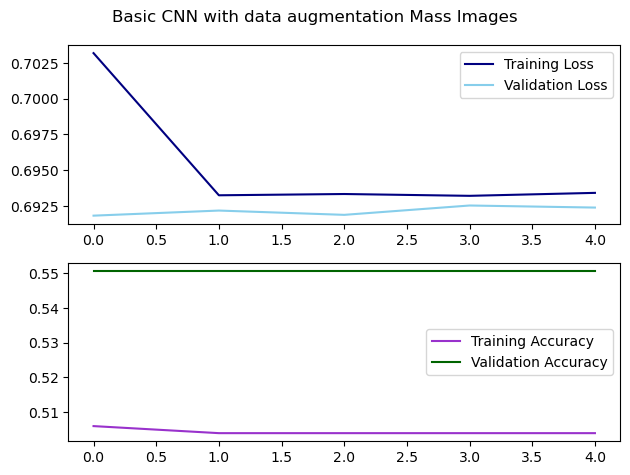

In [107]:
fig, axs = plt.subplots(2)
fig.suptitle("Basic CNN with data augmentation Mass Images")
axs[0].plot(hist_aug.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_aug.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()

axs[1].plot(hist_aug.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_aug.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Mass Basic CNN with data augmentation Loss and Accuracy.jpg',dpi = 200)

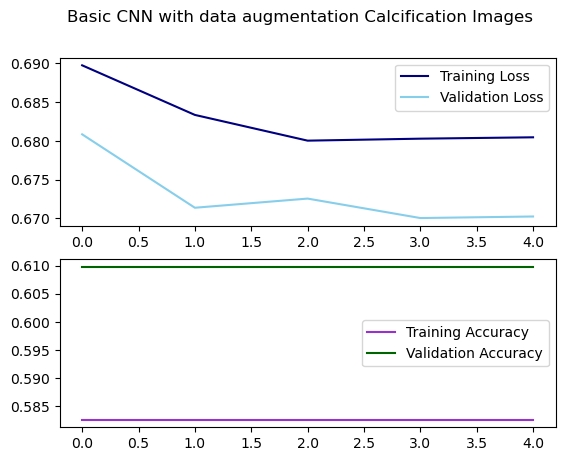

In [108]:
fig, axs = plt.subplots(2)
fig.suptitle("Basic CNN with data augmentation Calcification Images")
axs[0].plot(hist_aug_calc.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_aug_calc.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_aug_calc.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_aug_calc.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')

axs[1].legend()
plt.savefig('./Presentation/Figures/Calc Basic CNN with data augmentation Loss and Accuracy.jpg',dpi = 200);

### Pretrained Model  
#### ResNet50

In [49]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

In [50]:
inputs = keras.Input(shape=(512, 512, 3))
# x = data_aug(inputs)
# Only necessary since we did a data augmentation step!
x = conv_base(inputs)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [51]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [52]:
model.summary()

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 16, 16, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [53]:
hist_rn = model.fit(
    mass_train_ds, 
    validation_data=mass_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
    )

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3025s 95s/step - acc: 0.5489 - loss: 1.1135 - val_acc: 0.5506 - val_loss: 1792.9548
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2361s 76s/step - acc: 0.5344 - loss: 0.7035 - val_acc: 0.5506 - val_loss: 0.6908
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2474s 79s/step - acc: 0.5902 - loss: 0.7248 - val_acc: 0.5506 - val_loss: 0.6902
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2576s 83s/step - acc: 0.5922 - loss: 0.6819 - val_acc: 0.5506 - val_loss: 0.6897
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2333s 75s/step - acc: 0.6140 - loss: 0.6605 - val_acc: 0.5506 - val_loss: 0.6883


In [54]:
hist_rn_calc = model.fit(
    calc_train_ds, 
    validation_data=calc_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
    )

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2760s 88s/step - acc: 0.5613 - loss: 0.6946 - val_acc: 0.6098 - val_loss: 0.6749
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3167s 101s/step - acc: 0.6344 - loss: 0.6399 - val_acc: 0.6098 - val_loss: 0.6769
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2425s 78s/step - acc: 0.6166 - loss: 0.6329 - val_acc: 0.6098 - val_loss: 0.6845
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2240s 72s/step - acc: 0.6043 - loss: 0.6224 - val_acc: 0.6098 - val_loss: 0.6916
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2527s 81s/step - acc: 0.6448 - loss: 0.5925 - val_acc: 0.6098 - val_loss: 1.9400


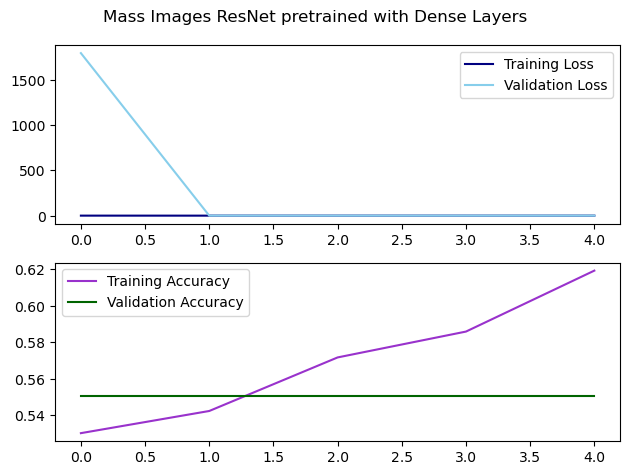

In [103]:
fig, axs = plt.subplots(2)
fig.suptitle("Mass Images ResNet pretrained with Dense Layers")
# plt.figure(figsize=(6, 5))
axs[0].plot(hist_rn.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_rn.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_rn.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_rn.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Mass ResNet pretrained with Dense Layer Loss and Accuracy.jpg',dpi = 200);

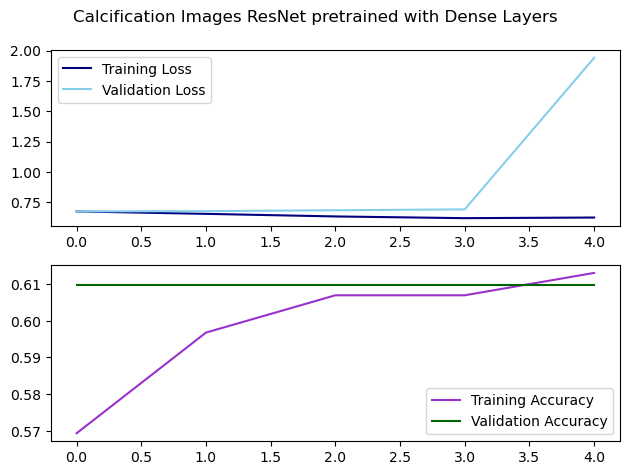

In [104]:
fig, axs = plt.subplots(2)
fig.suptitle("Calcification Images ResNet pretrained with Dense Layers")
# plt.figure(figsize=(6, 5))
axs[0].plot(hist_rn_calc.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_rn_calc.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_rn_calc.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_rn_calc.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Calcification ResNet pretrained with Dense Layer Loss and Accuracy.jpg',dpi = 200);

### Pretrained Mode  
#### VGG16

In [57]:
vgg_base = VGG16(
    weights='imagenet',
    include_top=False
)

for layer in vgg_base.layers:
    layer.trainable = False

In [58]:
inputs = keras.Input(shape=(512, 512, 3))
# x = data_aug(inputs)
# Only necessary since we did a data augmentation step!
x = vgg_base(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

vgg_model = keras.Model(inputs, outputs)

In [59]:
vgg_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [60]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_vgg = vgg_model.fit(
    mass_train_ds, 
    validation_data=mass_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
    )

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1136s 36s/step - acc: 0.4873 - loss: 0.7866 - val_acc: 0.4494 - val_loss: 0.7553
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1011s 32s/step - acc: 0.5147 - loss: 0.7063 - val_acc: 0.5506 - val_loss: 0.6796
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1002s 32s/step - acc: 0.5448 - loss: 0.7044 - val_acc: 0.4453 - val_loss: 0.7055
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1028s 33s/step - acc: 0.5518 - loss: 0.6993 - val_acc: 0.5587 - val_loss: 0.6753
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1040s 33s/step - acc: 0.5391 - loss: 0.6872 - val_acc: 0.5020 - val_loss: 0.6894


In [61]:
hist_vgg_calc = vgg_model.fit(
    calc_train_ds, 
    validation_data=calc_val_ds, 
    epochs=5,
    callbacks=[early_stopping]
    )

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 953s 30s/step - acc: 0.5307 - loss: 0.7041 - val_acc: 0.6098 - val_loss: 0.6557
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 950s 30s/step - acc: 0.6238 - loss: 0.6433 - val_acc: 0.6098 - val_loss: 0.6725
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 977s 31s/step - acc: 0.5736 - loss: 0.6711 - val_acc: 0.6098 - val_loss: 0.6569
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 964s 31s/step - acc: 0.6308 - loss: 0.6377 - val_acc: 0.6382 - val_loss: 0.6574
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 960s 31s/step - acc: 0.6066 - loss: 0.6586 - val_acc: 0.6098 - val_loss: 0.6494


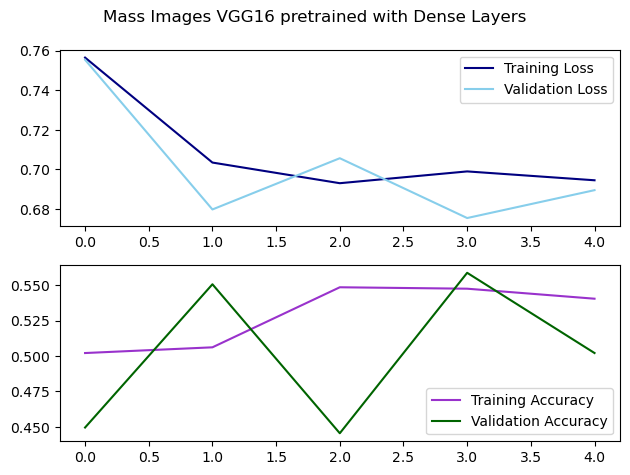

In [105]:
fig, axs = plt.subplots(2)
fig.suptitle("Mass Images VGG16 pretrained with Dense Layers")
# plt.figure(figsize=(6, 5))
axs[0].plot(hist_vgg.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_vgg.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_vgg.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_vgg.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Mass VGG16 pretrained with Dense Layer Loss and Accuracy.jpg',dpi = 200);

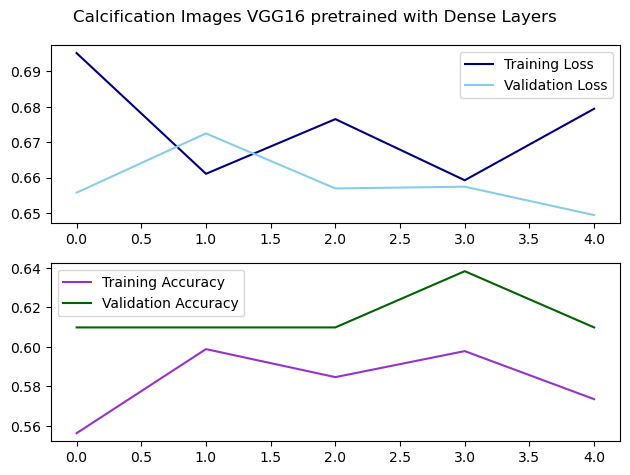

In [106]:
fig, axs = plt.subplots(2)
fig.suptitle("Calcification Images VGG16 pretrained with Dense Layers")
# plt.figure(figsize=(6, 5))
axs[0].plot(hist_vgg_calc.history['loss'], c='navy', label='Training Loss')
axs[0].plot(hist_vgg_calc.history['val_loss'], c='skyblue', label='Validation Loss')
axs[0].legend()
axs[1].plot(hist_vgg_calc.history['acc'], c = 'darkorchid', label = 'Training Accuracy')
axs[1].plot(hist_vgg_calc.history['val_acc'], c = 'darkgreen', label = 'Validation Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('./Presentation/Figures/Calcification VGG16 pretrained with Dense Layer Loss and Accuracy.jpg',dpi = 200);

## Model Evaluation

#### Basic CNN

In [85]:
_, train_acc =model_cnn.evaluate(mass_train_ds)
_, val_acc = model_cnn.evaluate(mass_val_ds)
print('Mass Train Basic CNN: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - acc: 0.5796 - loss: 0.7844
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - acc: 0.6095 - loss: 0.7333
Mass Train Basic CNN: 0.584, Test: 0.595


In [86]:
_, train_acc =model_cnn.evaluate(calc_train_ds)
_, val_acc = model_cnn.evaluate(calc_val_ds)
print('Calc Train Basic CNN: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - acc: 0.7631 - loss: 0.4617
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.6055 - loss: 0.6713
Calc Train Basic CNN: 0.775, Test: 0.610


#### CNN with Data Augmentation

In [87]:
_, train_acc =model_aug.evaluate(mass_train_ds)
_, val_acc = model_aug.evaluate(mass_val_ds)
print('Mass Train Basic CNN with Data Augmentation: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - acc: 0.5297 - loss: 0.6953
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - acc: 0.5573 - loss: 0.6871
Mass Train Basic CNN with Data Augmentation: 0.504, Test: 0.551


In [88]:
_, train_acc =model_aug.evaluate(calc_train_ds)
_, val_acc = model_aug.evaluate(calc_val_ds)
print('Calc Train Basic CNN with Data Augmentation: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - acc: 0.6006 - loss: 0.6743
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.6065 - loss: 0.6730
Calc Train Basic CNN with Data Augmentation: 0.583, Test: 0.610


#### ResNet50 Pretrained Model

In [89]:
_, train_acc =model.evaluate(mass_train_ds)
_, val_acc = model.evaluate(mass_val_ds)
print('Mass Train ResNet Pretrain: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 290s 9s/step - acc: 0.5122 - loss: 2.4426
8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - acc: 0.5179 - loss: 2.4270
Mass Train ResNet Pretrain: 0.504, Test: 0.551


In [94]:
_, train_acc =model.evaluate(calc_train_ds)
_, val_acc = model.evaluate(calc_val_ds)
print('Calc Train ResNet Pretrain: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - acc: 0.6179 - loss: 1.9295
8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - acc: 0.6090 - loss: 1.9675
Calc Train ResNet Pretrain: 0.583, Test: 0.610


#### VGG16 Pretrained Mode

In [91]:
_, train_acc =vgg_model.evaluate(mass_train_ds)
_, val_acc = vgg_model.evaluate(mass_val_ds)
print('Mass Train VGG16 Pretrain: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1826s 58s/step - acc: 0.5143 - loss: 0.6991
8/8 ━━━━━━━━━━━━━━━━━━━━ 259s 31s/step - acc: 0.5800 - loss: 0.6621
Mass Train VGG16 Pretrain: 0.504, Test: 0.551


In [95]:
_, train_acc =vgg_model.evaluate(calc_train_ds)
_, val_acc = vgg_model.evaluate(calc_val_ds)
print('Calc Train VGG16 Pretrain: %.3f, Test: %.3f' % (train_acc, val_acc))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1408s 45s/step - acc: 0.6052 - loss: 0.6377
8/8 ━━━━━━━━━━━━━━━━━━━━ 336s 41s/step - acc: 0.6139 - loss: 0.6458
Calc Train VGG16 Pretrain: 0.582, Test: 0.610


## Save best performed model

In [74]:
model_cnn.save('./Model/my_cnn_model.keras')